# Python workshop - 2025

<div>
    <img src="../images/qcbs_logo_v2.svg" style="background-color: #f0f0f0; padding: 20px;"/>
</div>

<div>
    <img src="../images/python_logo_generic.svg" style="background-color: #f0f0f0; padding: 20px;"/>
</div>

**Last update**: 2025-05-19  
**Author**: El-Amine Mimouni  
**Affiliation**: Québec Centre for Biodiversity Science

**Overview**: In this notebook, we will see how to work with raster data.

---

# Rasterio

## General information

Information on rasterio can be found at:
[https://rasterio.readthedocs.io/en/stable/index.html](https://rasterio.readthedocs.io/en/stable/index.html)

Though part of rasterio, information on affine can be found at:
[https://affine.readthedocs.io/en/latest/](https://affine.readthedocs.io/en/latest/)

In [1]:
# Today's star
import rasterio
import rasterio.plot
import rasterio.mask

# Other actors
import numpy as np
import pandas as pd
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# Change print options to show numbers in regular format
# (i.e. non-scientific notation)
np.set_printoptions(suppress=True)

# Image basics

In [4]:
# Read in an image
# For the moment just get metadata
with rasterio.open(fp="https://inaturalist-open-data.s3.amazonaws.com/photos/179312657/original.jpg", mode="r") as src:
    # Extract the metadata
    koala_meta = src.meta

c:\Users\elami\OneDrive\Desktop\python-workshop-fall-2025\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [5]:
koala_meta

{'driver': 'JPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1769,
 'height': 1769,
 'count': 3,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [6]:
with rasterio.open("https://inaturalist-open-data.s3.amazonaws.com/photos/179312657/original.jpg") as src:
    band_r = src.read(1)
    band_g = src.read(2)
    band_b = src.read(3)

# Stack bands into an RGB image and transpose for plotting
# The parameter axis=-1 sets the new dimension (in this case
# color channel) to be the last dimension (i.e. -1).
rgb_image = np.stack(arrays=(band_r, band_g, band_b), axis=-1)

# Too bad we can't see pillow...

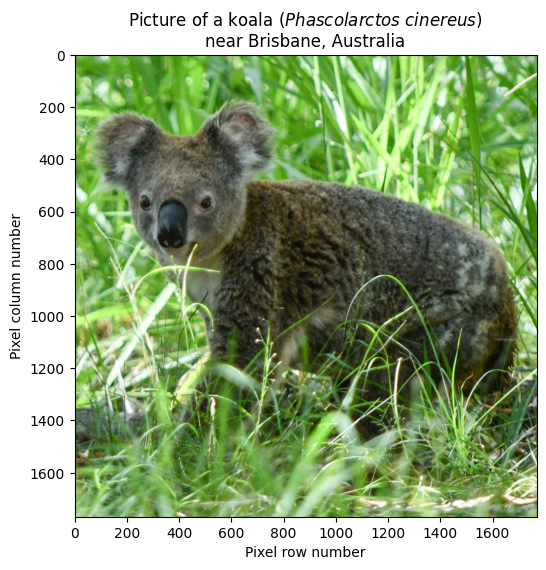

In [7]:
# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Display the raster using imshow
img = ax.imshow(X=rgb_image)

# Label axes and title
# We're entering dangerous LaTeX territory...
ax.set_title(label="Picture of a koala ($\\mathit{Phascolarctos\\ cinereus}$)\nnear Brisbane, Australia")
ax.set_xlabel(xlabel="Pixel row number")
ax.set_ylabel(ylabel="Pixel column number")

# Show plot (IRL/JK)
plt.show()

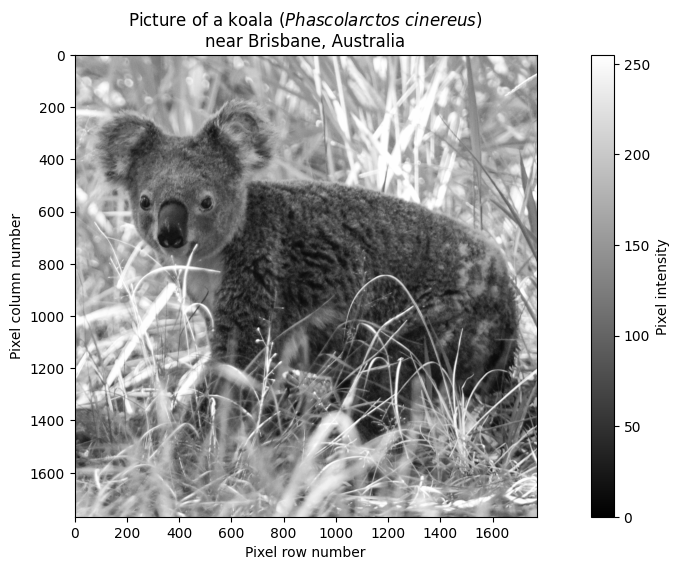

In [8]:
# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Display the raster using imshow
img = ax.imshow(X=band_g, cmap="gray")

# Label axes and title
ax.set_title(label="Picture of a koala ($\\mathit{Phascolarctos\\ cinereus}$)\nnear Brisbane, Australia")
ax.set_xlabel(xlabel="Pixel row number")
ax.set_ylabel(ylabel="Pixel column number")

# Add a scalebar
fig.colorbar(img, ax=ax, shrink=1.0, label="Pixel intensity")

# Show plot (IRL/JK)
plt.show()

*Photo by [Penelope Lind](https://www.inaturalist.org/people/plind) on [iNaturalist](https://www.inaturalist.org/observations/106709637), licensed under [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/).*

# Onwards with georeferenced data

In [ ]:
# Read in WorldClim data
# For the moment just get metadata
with rasterio.open(fp="/vsizip/vsicurl/https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_5m_bio.zip/wc2.1_5m_bio_3.tif", mode="r") as src:
    # Extract the metadata
    src_meta = src.meta
    # This will be very useful later
    src_extent = rasterio.plot.plotting_extent(src)

In [ ]:
# Look at the metadata
print("Metadata dictionary:")
src_meta

In [ ]:
# CRS does not look to be our conventional PyProj CRS
print(src_meta["crs"])
print(type(src_meta["crs"]))

In [ ]:
# Proofo PyProjo
# Convert to pyproj CRS
pyproj_crs = pyproj.CRS.from_user_input(src_meta["crs"])

# Look at it!
print(pyproj_crs)
print(type(pyproj_crs))

In [ ]:
# Read in WorldClim data
# This time extract band1
# Note: Rasterio uses GDAL numbering so first band is 1
with rasterio.open(fp="/vsizip/vsicurl/https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_5m_bio.zip/wc2.1_5m_bio_1.tif", mode="r") as src:
    # Read in the first band
    bio1 = src.read(1)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Display the raster using imshow
#
# Technically you'll only get the occasional overflow error,
# but it is better to use img = ax.imshow() rather than just
# using ax.imshow()
img = ax.imshow(X=bio1, cmap="gray")

# Label axes and title
ax.set_title(label="Annual mean temperature (BIO1)")
ax.set_xlabel(xlabel="Pixel row number")
ax.set_ylabel(ylabel="Pixel column number")

# Add a colorbar
fig.colorbar(img, ax=ax, shrink=0.7, label="Annual mean temperature (in \u00B0C)")

# Show plot (IRL/JK)
plt.show()

In [ ]:
# Extract the affine matrix (src_trans)
src_trans = src_meta["transform"]

# Look at it!
print("The affine matrix (Affine version):")
print(src_trans)
print(type(src_trans))

In [ ]:
# It's an Affine type matrix, but still a matrix
# (i.e. type are not so important here)
A = np.array(object=src_trans).reshape(3, 3)

print("The affine matrix (NumPy version):")
print(A)
print(type(A))

In [ ]:
# The affine matrix is key to allowing translation from pixel-space
# to geographic-space

# For the first pixel (0, 0)
first_pixel = np.array([[0, 0, 1]]).T

# Note: For those of you that wonder, you could also use
# Note^2: In the first case, the -1 implies "as many as
# necessary" so that it conforms
# first_pixel = np.array([[0, 0, 1]]).reshape((-1, 1))
# first_pixel = np.array([[0], [0], [1]])


# See the values of the first pixel
print("Pixel-coordinates of the first pixel (with 1 appended):")
print(first_pixel)
print(first_pixel.shape)

In [ ]:
# The real world coordinates of the firs pixel is simply
# the product with the affine matrix A

# See the values of the first pixel
print("\nGeographic coordinates of the first pixel (with 1 appended):")
print(A @ first_pixel)

In [ ]:
# For the last pixel (width-1, height-1)
last_pixel = np.array([[4320-1, 2160-1, 1]]).T

# See the values of the first pixel
print("Pixel-coordinates of the last pixel (with 1 appended):")
print(last_pixel)

# See the values of the first pixel
print("\nGeographic coordinates of the last pixel (with 1 appended):")
print(A @ last_pixel)

In [ ]:
# For a random pixel (2156, 1845)
rand_pixel = np.array([[2156, 1845, 1]]).T

# See the values of the first pixel
print("Pixel-coordinates of a random pixel (with 1 appended):")
print(rand_pixel)

# See the values of the first pixel
print("\nGeographic coordinates of a random pixel (with 1 appended):")
print(A @ rand_pixel)

In [ ]:
# Numerical algebra quizzzzzzzz
print("The determinant of A:")
print(np.linalg.det(a=A))

# It is not equal to 0, so the matrix can be inverted
# Yipeeee

In [ ]:
# SPAT_COO = A * PIX_XY
#
# A * PIX_XY = SPAT_COO
# Am1 * A * PIX_X1 = Am1 * SPAT_COO
# I * PIX_X1 = Am1 * SPAT_COO
# PIX_X1 = Am1 * SPAT_COO

In [ ]:
# Considering the inverse affine matrix means we can do the opposite translation

# Inverse affine:
# Using the affine object
print("Inverse of A (Affine version):")
print(~src_trans)
print(type(~src_trans))

# Using the NumPy matrix
Am1 = np.linalg.inv(a=A)

# Look at it!
print("\nInverse of A (NumPy version):")
print(Am1)
print(type(Am1))

In [ ]:
# Load the first five observations of desert pea.
# We can be quick about it, no need for intermediate steps.
# I take the time to remind you that .loc[] is location based,
# so that 5 observations will be selected.
pea5 = pd.read_csv(filepath_or_buffer="../data/desert_pea.csv").loc[0:4 ,["decimalLongitude", "decimalLatitude"]]

# Append a colmn of 1's
pea5_1 = np.hstack((pea5, np.ones(5).reshape(5, 1)))

print("\nCoordinates of first five observations with a column of 1s:")
print(pea5_1.T)

In [ ]:
# See the values of each cells
print("\nPixel coordinates of first five observations with a column of 1s:")
print(Am1 @ pea5_1.T)

print("\nRounded pixel coordinates of first five observations with a column of 1s:")
print(np.round(Am1 @ pea5_1.T))

In [ ]:
# Get the pixel coordinates
pea5_pixel = np.round(Am1 @ pea5_1.T)

In [ ]:
# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Display the raster using imshow
img = ax.imshow(X=bio1, cmap="gray")

# Add the first five desert peas!!!!!
ax.scatter(x=pea5_pixel[0, :], y=pea5_pixel[1, :], marker="+", color="red", s=35)

# Label axes and title
ax.set_title(label="Annual mean temperature (BIO1))")
ax.set_xlabel(xlabel="Pixel row number")
ax.set_ylabel(ylabel="Pixel column number")

# Add a colorbar
fig.colorbar(img, ax=ax, shrink=0.7, label="Annual mean temperature (in \u00B0C)")

# Show plot
plt.show()

In [ ]:
# Finally, considering actual spatial coordinates
# See that thing we extracted before
print("The extent of the image:")
print(src_extent)
print(type(src_extent))

In [ ]:
# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Display the raster using imshow
img = ax.imshow(X=bio1, cmap="gray", extent=src_extent)

# Label axes and title
ax.set_title(label="Annual mean temperature (BIO1)")
ax.set_xlabel(xlabel="Longitude")
ax.set_ylabel(ylabel="Latitude")

# Add a colorbar
fig.colorbar(img, ax=ax, shrink=0.7, label="Annual mean temperature (in \u00B0C)")

# Show plot
plt.show()

# Masks and whatnot

In [ ]:
# ENOUGH IS ENOUGH

# Look at the data
print(bio1)
print(type(bio1))

# 10^30 is a sedecillion.
# 10^36 is a duodecillion.
# 10^39 is a tredecillion.

In [ ]:
# Read in WorldClim data
# This time extract band1
# Note: Rasterio uses GDAL numbering so first band is 1 (AGAIN)
with rasterio.open(fp="/vsizip/vsicurl/https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_5m_bio.zip/wc2.1_5m_bio_1.tif", mode="r") as src:
    # Read in the first band
    bio1_m = src.read(1, masked=True)

# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Display the raster using imshow
img = ax.imshow(X=bio1_m, cmap="gray", extent=src_extent)

# Label axes and title
ax.set_title(label="Annual mean temperature (BIO1))")
ax.set_xlabel(xlabel="Longitude")
ax.set_ylabel(ylabel="Latitude")

# Add a colorbar
fig.colorbar(img, ax=ax, shrink=0.7, label="Annual mean temperature (in \u00B0C)")

# Show plot
plt.show()

In [ ]:
# Look at the newly changed data
print(bio1_m)
print(type(bio1_m))

In [ ]:
# BTW JFK
# If you want to see the available colormaps in matplotlib
print(plt.colormaps())

# Rasters a numpy arrays

This means we can do more than just plotting.

In [ ]:
# Using the same method, fetch data for:
# - BIO2 (mean diurnal range)
# - BIO5 (maximum temperature of the warmest month)
# - BIO6 (minimum temperature of the coldest month)

# Different calls because they are on different .zip files.
with rasterio.open(fp="/vsizip/vsicurl/https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_5m_bio.zip/wc2.1_5m_bio_2.tif", mode="r") as src:
    bio2 = src.read(1, masked=True)

with rasterio.open(fp="/vsizip/vsicurl/https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_5m_bio.zip/wc2.1_5m_bio_5.tif", mode="r") as src:
    bio5 = src.read(1, masked=True)

with rasterio.open(fp="/vsizip/vsicurl/https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_5m_bio.zip/wc2.1_5m_bio_6.tif", mode="r") as src:
    bio6 = src.read(1, masked=True)

In [ ]:
# Compute BIO3 (isothemality) "by hand" (if your hand was a computer)
#
bio3 = bio2 / (bio5 - bio6) * 100.0

In [ ]:
# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Display the raster using imshow
# BTW they all have the same extent so we can use the same one
img = ax.imshow(X=bio3, cmap="magma", extent=src_extent)

# Label axes and title
ax.set_title(label="Isothermality (BIO3))")
ax.set_xlabel(xlabel="Longitude")
ax.set_ylabel(ylabel="Latitude")

# Add a colorbar
fig.colorbar(img, ax=ax, shrink=0.7, label="Isothermality")

# Show plot
plt.show()

In [ ]:
# Just for kicks, read the actual BIO3
with rasterio.open(fp="/vsizip/vsicurl/https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_5m_bio.zip/wc2.1_5m_bio_3.tif", mode="r") as src:
    bio3_web = src.read(1, masked=True)

# Create a scatter plot comparing the two
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))
ax.set_aspect(aspect="equal", adjustable="datalim")

# Show scatterplot
ax.scatter(bio3_web.flatten(), bio3.flatten(), s=10)

# Add the 1:1 line (y = x)
ax.plot([0, 100], [0, 100], color="red", linestyle="dashed", label="1:1 line")

# Labeling the axes and title
ax.set_title(label="Comparison of two BIO3 variables")
ax.set_xlabel(xlabel="BIO3 obtained online")
ax.set_ylabel(ylabel="BIO3 computed in this workshop")

# Show legend
ax.legend()

# Add abcissa and ordinate
ax.axvline(x=0, color="black", linestyle="dashed", linewidth=1)
ax.axhline(y=0, color="black", linestyle="dashed", linewidth=1)

# Show the plot
plt.show()

# Cropping rasters

In [ ]:
# Go fetch the Australian territories data once more.
# Convert it to EPSG4326, the same CRS as the WORLDCLIM data.
gdf_aus = gpd.read_file(filename="https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/STE_2021_AUST_SHP_GDA2020.zip")
gdf_aus.to_crs(crs=4326, inplace=True)

In [ ]:
# Open the raster (WorldClim data) with rasterio
with rasterio.open(fp="/vsizip/vsicurl/https://geodata.ucdavis.edu/climate/worldclim/2_1/base/wc2.1_5m_bio.zip/wc2.1_5m_bio_13.tif") as src:
    # DISREGARD THE LAST "GEOMETRY"
    # WHY YOU EXIST FOR ONLY A LINK?!?!?!
    out_array, out_transform = rasterio.mask.mask(dataset=src, shapes=[gdf_aus.geometry[6]], crop=True, filled=True)

# IF JUST ONE IT NEEDS TO BE A LIST
#    out_image, out_transform = mask(src, [gdf_aus.geometry[2]], crop=True, filled=True)
#    out_image, out_transform = mask(src, gdf_aus.geometry[0:9], crop=False, filled=True)
#    out_image, out_transform = mask(src, gdf_aus.geometry[0:4].to_list(), crop=True, filled=True)

    # IMPORTANT: You need to update the metadata to reflect the newly
    # cropped raster. It no longer has the same dimensions or affine
    # matrix.
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "count": 1,
        "dtype": "float32",
        "crs": src.crs,
        "transform": out_transform,
        "width": out_array.shape[2],
        "height": out_array.shape[1]
    })

# BTW: We use "height": out_array.shape[1] and "width": out_array.shape[2]
# because the NumPy array is indexed by (band x height x width).
# Check it out with out_array.shape.

In [ ]:
# See that some things have CHANGED
print("The cropped affine matrix (Affine version)")
print(out_meta["transform"])

In [ ]:
# See that some things have CHANGED
print("The width of the image")
print(out_meta["width"])
#
print("\nThe height of the image")
print(out_meta["height"])

In [ ]:
# Save the cropped raster to a new file
# Pass the metadata as kwargs
with rasterio.open(fp="../data/austo.tif", mode="w", **out_meta) as dest:
    dest.write(out_array)

In [ ]:
# Open the raster file we created in the above cell to extract the data
with rasterio.open(fp="../data/austo.tif", mode="r") as src:
    bio13_crop = src.read(1, masked=True)

    # Here SUPER important!
    # You cropped the image, so the extent has changed
    src_extent_crop = rasterio.plot.plotting_extent(src)

In [ ]:
# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Display the raster using imshow
img = ax.imshow(X=bio13_crop, cmap="turbo", extent=src_extent_crop)

# Label axes and title
ax.set_title(label="Precipitation of the wettest month (BIO13)\ncropped Australia - Northern Territory version")
ax.set_xlabel(xlabel="Longitude")
ax.set_ylabel(ylabel="Latitude")

# Add a colorbar
fig.colorbar(img, ax=ax, shrink=0.7, label="Precipitation of the wettest month (in mm)")

# Overlay boundary
gdf_aus.boundary.plot(ax=ax, color="red", linewidth=0.5)

plt.show()

In [ ]:
# Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 10))

# Display the raster using imshow
#img = ax.imshow(X=bio13_crop, cmap="turbo")
img = ax.imshow(X=bio13_crop, cmap="turbo", extent=src_extent_crop)

# Label axes and title
ax.set_title(label="Precipitation of the wettest month (BIO13)\ncropped Australia - Northern Territory version")
ax.set_xlabel(xlabel="Longitude")
ax.set_ylabel(ylabel="Latitude")

# Add a colorbar
fig.colorbar(img, ax=ax, shrink=1.0, label="Precipitation of the wettest month (in mm)")

# Show the plot
plt.show()